In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re

from sklearn import preprocessing

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import seaborn as sns
sns.set()
%matplotlib inline
import string

import os 
from datetime import datetime
import random
import math

from sklearn.cross_validation import train_test_split

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [18]:
def preprocess(df):
    # reassign id
#     df.index = df.PassengerId

    # drop not imp data
#     df.drop("PassengerId", axis=1, inplace=True)
    
    # avg_age
#     avg_age = df['Age'].mean()
    avg_age = df['Age'].median()
#     std = df['Age'].std()
#     mean = df['Age'].mean()
#     size = len(df[pd.isnull(df['Age'])])
#     age_null_random_list = np.random.randint(mean - std, mean + std, size=size)
#     df.loc[pd.isnull(df['Age']), 'Age'] = age_null_random_list
    
    # age
#     age_range = list(set(pd.qcut(df[pd.notnull(df['Age'])]['Age'], 5)))
#     def agecat(age):
#         if age in age_range[0]:
#             cat = 0
#         elif age in age_range[1]:
#             cat = 1
#         elif age in age_range[2]:
#             cat = 2
#         elif age in age_range[3]:
#             cat = 3
#         else:
#             cat = 4
#         return cat
    
    def agecat(age):
        if age <= 16:
            cat = 0
        elif age > 16 and age <= 32:
            cat = 1
        elif age > 32 and age <= 48:
            cat = 2
        elif age < 48 and age <= 64:
            cat = 3
        else:
            cat = 4
        return cat
    
    
    # fare
#     fare_range = list(set(pd.qcut(df[pd.notnull(df['Fare'])]['Fare'], 7)))
#     def farecat(f):
#         if f in fare_range[0]:
#             cat = 0
#         elif f in fare_range[1]:
#             cat = 1
#         elif f in fare_range[2]:
#             cat = 2
#         elif f in fare_range[3]:
#             cat = 3
#         elif f in fare_range[4]:
#             cat = 4
#         elif f in fare_range[5]:
#             cat = 5
#         else:
#             cat = 6
#         return cat
    
    
    def farecat(f):
        if f <= 16:
            cat = 0
        elif f > 17 and f <= 32:
            cat = 1
        elif f > 32 and f <= 48:
            cat = 2
        elif f < 48 and f <= 64:
            cat = 3
        elif f < 64 and f <= 80:
            cat = 4
        elif f < 80 and f <= 96:
            cat = 5
        else:
            cat = 6
        return cat

    
    # avg_fare
    fares_notnull = df[pd.notnull(df['Fare'])]['Fare']
    avg_fare = fares_notnull.median()

    # ticket
    ticket_cat = {}
    for ticket in df['Ticket']:
        if ticket.isdigit():
            ticket_cat[ticket] = 1
        elif ticket.startswith('A'):
            ticket_cat[ticket] = 2
        elif ticket.startswith('C'):
            ticket_cat[ticket] = 3
        elif ticket.startswith('F'):
            ticket_cat[ticket] = 4
        elif ticket.startswith('P'):
            ticket_cat[ticket] = 5
        elif ticket.startswith('SOTON'):
            ticket_cat[ticket] = 6
        elif ticket.startswith('STON'):
            ticket_cat[ticket] = 7
        elif ticket.startswith('S'):
            ticket_cat[ticket] = 8
        elif ticket.startswith('W'):
            ticket_cat[ticket] = 9
        else:
            ticket_cat[ticket] = 0
            
    ticket_cat1 = {}
    for num, name in enumerate(list(set([item.split()[0].replace(".", "").replace("/", "") for item in df['Ticket'] if not item.isdigit()]))):
        ticket_cat1[name] = num
    
    # cabin
    cabin_cat = {}
    for cabin in df['Cabin']:
        if pd.isnull(cabin):
            cabin_cat[cabin] = 0
        elif cabin.startswith('A'):
            cabin_cat[cabin] = 1
        elif cabin.startswith('B'):
            cabin_cat[cabin] = 2
        elif cabin.startswith('C'):
            cabin_cat[cabin] = 3
        elif cabin.startswith('D'):
            cabin_cat[cabin] = 4
        elif cabin.startswith('E'):
            cabin_cat[cabin] = 5
        else:
            cabin_cat[cabin] = 0
    
    # embarked
    embarked_cat = {}
    for embarked in df['Embarked']:
        if pd.isnull(embarked):
            embarked_cat[embarked] = 0
        elif embarked.startswith('S'):
            embarked_cat[embarked] = 0
        elif embarked.startswith('Q'):
            embarked_cat[embarked] = 1
        elif embarked.startswith('C'):
            embarked_cat[embarked] = 2
            
            
    # title
    title_mapping= {
        'Ms':"Miss",
        'Mlle':"Miss",
        'Miss':"Miss",
        'Mrs':"Mrs",
        'Mme':"Mrs",
        'MrsMartin(ElizabethL':"Mrs",
        'Mr':"Mr"
        }
    
    title_cat = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    
    # Name_with specail chars
    def withspecailchar(name):
        for char in name:
            if char in string.punctuation:
                return 1
        return 0
    
    def applyfun(row):
#         row['Has_Cabin'] = 0 if pd.isnull(row['Cabin']) else 1
        row['Cabin'] = cabin_cat.get(row['Cabin'])

        row['Age'] = row['Age'] if pd.notnull(row['Age']) else avg_age
#         row['Age_Cat'] = agecat(row['Age'])
#         row['Age_Lower_than_15'] = 1 if row['Age'] < 15 else 0
#         row['Age_Higher_than_75'] = 1 if row['Age'] > 75 else 0

        row['Fare'] = row['Fare'] if pd.notnull(row['Fare']) else avg_fare
#         row['Fare_log10'] = math.log(row['Fare'], 10) if  row['Fare'] != 0 else 0
#         row['Fare_log2'] = math.log(row['Fare'], 2) if  row['Fare'] != 0 else 0

#         row['Fare_Cat'] = farecat(row['Fare'])
#         row['High_Price_Fare'] = 1 if row['Fare'] > 200 else 0

        row['Ticket'] = ticket_cat.get(row['Ticket'])
        processed_ticket = row['Ticket'].split()[0].replace(".", "").replace("/", "") if not str(row['Ticket']).isdigit() else None
#         row['Ticket1'] = ticket_cat1.get(processed_ticket) if processed_ticket != None else 30

        row['Embarked'] = embarked_cat.get(row['Embarked'])
        row['Sex'] = 1 if row['Sex'] == 'male' else 0

        row['Name_Length'] = len(row['Name'])
        row['Name_With_Special_Char'] = withspecailchar(row['Name'].replace(',', "").replace('.', ""))
        row['Family_Size'] = row['SibSp'] + row['Parch']
        row['Is_Alone']= 1 if row['Family_Size'] == 1 else 0
        
        call = re.search(r'\,.+\.', row['Name']).group(0).replace(",", "").replace(".", "").replace(" ", "")
        call_cat = title_cat.get(title_mapping.get(call, "Rare"))
        row['Title'] = call_cat
#         row['Mother'] = 1 if row['Age'] >18 and row['Parch'] > 0 and call != 'Miss' else 0
        return row
    
    df = df.apply(applyfun, axis=1)
    df.drop('Name', axis=1, inplace=True)
#     df.drop('Fare', axis=1, inplace=True)


    return df

In [19]:
df = pd.read_csv('train.csv')
df = preprocess(df)

# 1. Data Description

In [4]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Cabin', 'Embarked', 'Has_Cabin', 'Age_Cat',
       'Age_Lower_than_15', 'Age_Higher_than_75', 'Fare_log10', 'Fare_log2',
       'Fare_Cat', 'High_Price_Fare', 'Name_Length', 'Name_With_Special_Char',
       'Family_Size', 'Is_Alone', 'Title'],
      dtype='object')

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,...,Age_Higher_than_75,Fare_log10,Fare_log2,Fare_Cat,High_Price_Fare,Name_Length,Name_With_Special_Char,Family_Size,Is_Alone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.361582,0.523008,0.381594,2.017957,0.648709,0.463524,...,0.001122,1.256781,4.174938,1.303030,0.022447,26.965208,0.217733,0.904602,0.180696,1.773288
std,257.353842,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,2.059702,1.376792,0.791503,...,0.033501,0.435553,1.446877,1.977452,0.148214,9.281607,0.412937,1.613459,0.384982,1.143720
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.898198,2.983748,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,1.000000
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.159994,3.853417,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,2.000000,0.000000,1.000000,...,0.000000,1.491362,4.954196,1.000000,0.000000,30.000000,0.000000,1.000000,0.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,9.000000,5.000000,2.000000,...,1.000000,2.709549,9.000927,6.000000,1.000000,82.000000,1.000000,10.000000,1.000000,5.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
PassengerId               891 non-null int64
Survived                  891 non-null int64
Pclass                    891 non-null int64
Sex                       891 non-null int64
Age                       891 non-null float64
SibSp                     891 non-null int64
Parch                     891 non-null int64
Ticket                    891 non-null int64
Cabin                     891 non-null int64
Embarked                  891 non-null int64
Has_Cabin                 891 non-null int64
Age_Cat                   891 non-null int64
Age_Lower_than_15         891 non-null int64
Age_Higher_than_75        891 non-null int64
Fare_log10                891 non-null float64
Fare_log2                 891 non-null float64
Fare_Cat                  891 non-null int64
High_Price_Fare           891 non-null int64
Name_Length               891 non-null int64
Name_With_Special_Char    891 non-

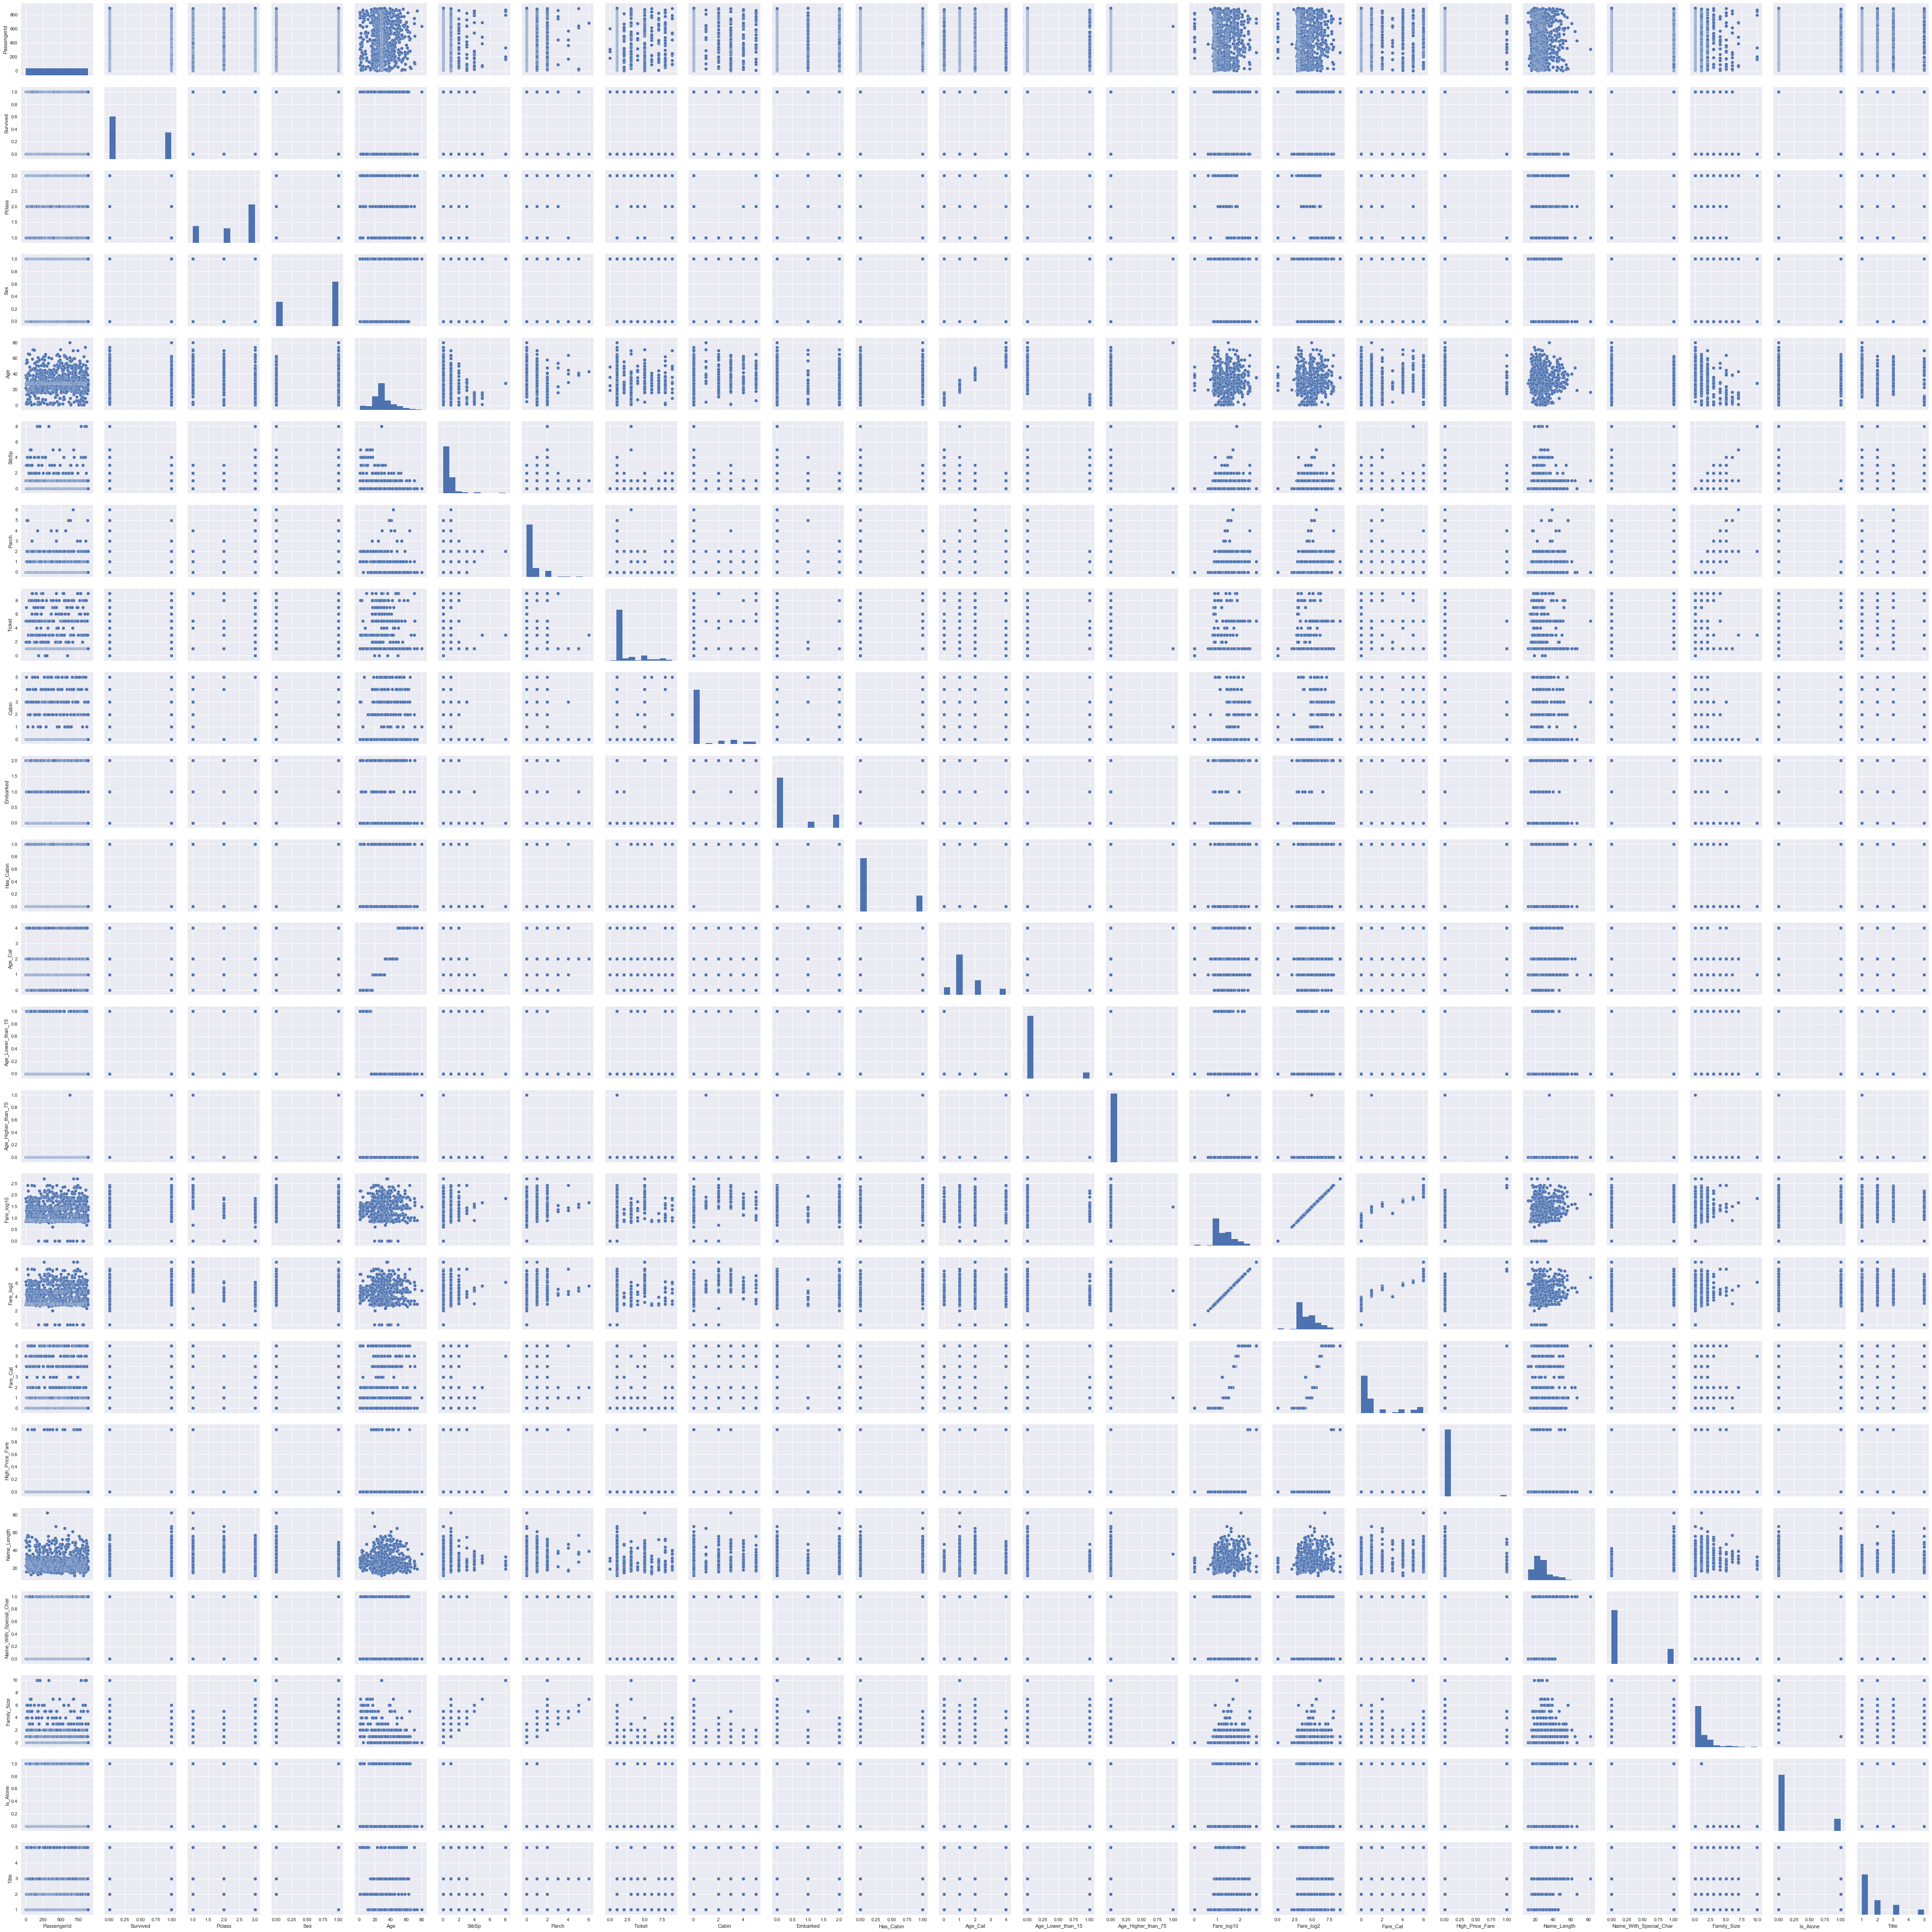

In [8]:
sns.pairplot(df)

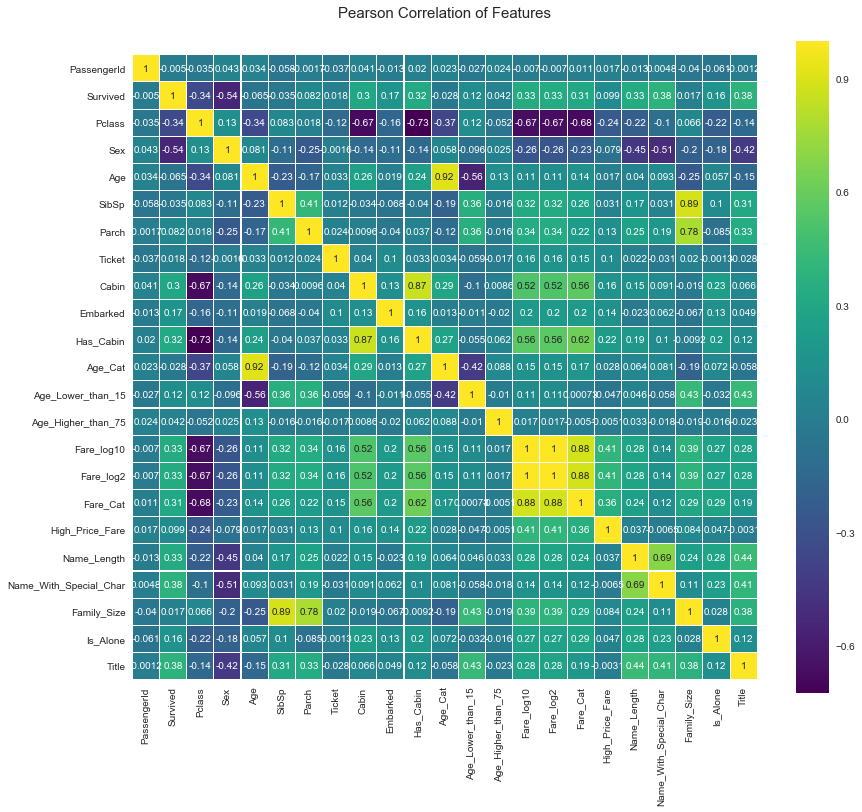

In [9]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

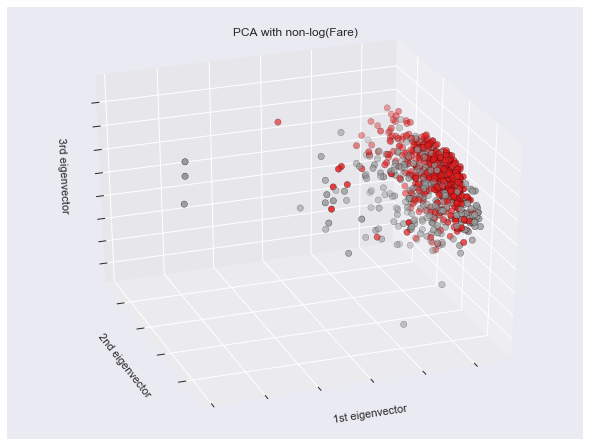

In [20]:
X = np.matrix(df.drop(['Survived','PassengerId'], axis=1))
Y = np.array(df['Survived'])

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("PCA with non-log(Fare)")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

# 2. Models

## SVM

In [11]:
# Input Data Preparation
X = np.matrix(df.drop(['Survived','PassengerId'], axis=1))
Y = np.array(df['Survived'])

print(X.shape)
print(Y.shape)
print(sum(Y)/len(Y))

(891, 21)
(891,)
0.383838383838


In [14]:
# Finally, we split some of the data off for validation
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=4242)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(712, 21)
(179, 21)
(712,)
(179,)


In [15]:
from sklearn.svm import SVC
svm = SVC(C=1, kernel='linear')
svm.fit(x_train, y_train) 

y_pred = svm.predict(x_valid)
print("Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0], pd.Series(y_valid != y_pred).astype(int).sum()))
y_pred = svm.predict(x_train)
print("Number of mislabeled points out of a total %d points : %d" % (x_train.shape[0], pd.Series(y_train != y_pred).astype(int).sum()))

Number of mislabeled points out of a total 179 points : 37
Number of mislabeled points out of a total 712 points : 123


## XGB

In [16]:
# plot decision tree
from xgboost import XGBClassifier

# fit model no training data
xgb1 = XGBClassifier(learning_rate=0.4, n_estimators=200)
xgb1.fit(x_train, y_train)

y_pred = xgb1.predict(x_train)
print("Number of mislabeled points out of a total %d points : %d" % (x_train.shape[0],(y_train != y_pred).sum()))
y_pred = xgb1.predict(x_train)
print("Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0], pd.Series(y_valid != y_pred).astype(int).sum()))

Number of mislabeled points out of a total 712 points : 16
Number of mislabeled points out of a total 179 points : 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


## Cross-Validation

In [17]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.04
## learning rate: Lower values generalize well.
params['max_depth'] = 4
## control over-fitting, higher depth specific to a particular sample.

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 200, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-logloss:0.671941	valid-logloss:0.674363
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.525316	valid-logloss:0.549909
[20]	train-logloss:0.444761	valid-logloss:0.48827
[30]	train-logloss:0.39641	valid-logloss:0.455919
[40]	train-logloss:0.366459	valid-logloss:0.442165
[50]	train-logloss:0.345667	valid-logloss:0.433864
[60]	train-logloss:0.331647	valid-logloss:0.433532
[70]	train-logloss:0.321084	valid-logloss:0.432086
[80]	train-logloss:0.311952	valid-logloss:0.433094
[90]	train-logloss:0.3041	valid-logloss:0.435119
[100]	train-logloss:0.295688	valid-logloss:0.436681
[110]	train-logloss:0.290531	valid-logloss:0.43806
[120]	train-logloss:0.287239	valid-logloss:0.439703
[130]	train-logloss:0.283307	valid-logloss:0.43991
[140]	train-logloss:0.279393	valid-logloss:0.439489
[150]	train-logloss:0.27567	valid-logloss:0.440171
[160]	train-logloss:0.271756	valid

In [18]:
y_pred = bst.predict(xgb.DMatrix(x_valid)) > 0.5
print("Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0],(y_valid != y_pred).sum()))

Number of mislabeled points out of a total 179 points : 30


# 3. Prediction

In [ ]:
df_test = pd.read_csv('test.csv')
ID = df_test['PassengerId']
df_test = preprocess(df_test.drop('PassengerId', axis=1))

X_test = np.matrix(df_test)

# y_pred = bst.predict(xgb.DMatrix(X_test))
y_pred = xgb1.predict(X_test)
print(X_test.shape)
print(y_pred.shape)

In [ ]:
df_submit = pd.DataFrame()
df_submit['PassengerId'] = ID
df_submit['Survived'] = (y_pred > 0.5) * 1
# df_submit['Survived'] = 0
df_submit.to_csv("submit.csv", index=False)